In [41]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 


from sklearn.model_selection import GridSearchCV  
from ydata_profiling import ProfileReport
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
df_contract = pd.read_csv("data/contract.csv")
df_internet = pd.read_csv("data/internet.csv")
df_personal = pd.read_csv("data/personal.csv")
df_phone = pd.read_csv("data/phone.csv")

In [4]:
dfs = [df_contract,df_internet,df_personal,df_phone]

for doc in dfs:
    doc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-nu

Voy a unir todos los dfs en el custumerID para tener todo en una tabla 

In [9]:
df_merged = df_contract.merge(df_personal, on='customerID', how='left')\
                       .merge(df_phone, on='customerID', how='left')\
                       .merge(df_internet, on='customerID', how='left')

In [10]:
df_merged["TotalCharges"] = pd.to_numeric(df_merged["TotalCharges"], errors="coerce")


Despues de ver las correlaciones de las variables, puedo concluir que Total_charges tiene mucha coorelacion

 type, StreamingMovies, StreamingTV, TechSupport no tienen tanta pero influyen moderadamente

 Las demas tienen un indice de menos de 0.200 y la que no tiene correlacion es la de genero 

 Podria quitar las variables de genero y paperless billing a mi parecer 

In [11]:
cancelar_y_streaming = df_merged[(df_merged['EndDate'] != "No") &  ((df_merged['StreamingMovies'] == "Yes") | (df_merged['StreamingTV'] == "Yes"))]

cancelar_y_streaming = cancelar_y_streaming.groupby(['StreamingMovies', 'StreamingTV']).size().reset_index(name='Count')

cancelar_y_streaming = cancelar_y_streaming.sort_values(by='Count', ascending=False)



print(cancelar_y_streaming)



  StreamingMovies StreamingTV  Count
2             Yes         Yes    571
1             Yes          No    247
0              No         Yes    243


Aqui se puede ver que cuando el plan tiene streaming movies y streaming tv es mas probable que cancelen

In [12]:
pareja = df_merged[["Partner", "EndDate"]]

pareja["Partner"] = pareja["Partner"].replace({"Yes": 1, "No": 0})

pareja["EndDate"] = np.where(pareja["EndDate"] == "No", 0, 1)

pareja.corr()


C:\Users\Pedro Alvarez\AppData\Local\Temp\ipykernel_19676\3079222968.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pareja["Partner"] = pareja["Partner"].replace({"Yes": 1, "No": 0})
C:\Users\Pedro Alvarez\AppData\Local\Temp\ipykernel_19676\3079222968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pareja["Partner"] = pareja["Partner"].replace({"Yes": 1, "No": 0})
C:\Users\Pedro Alvarez\AppData\Local\Temp\ipykernel_19676\3079222968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,Partner,EndDate
Partner,1.000000,-0.150448
EndDate,-0.150448,1.000000


Esto nos enseña que hay una relacion negativa leve entre tener pareja y cancelar el contrato, entonces se podria implementar un plan para parejas o algo por el estilo 

Tambien se podria pensar que entre mas tiempo estan con la compañia, mas es probable que se vayan por lo que podrian meter una promocion para socios que ya llevan mucho tiempo, basandonos en la correlacion de total y enddate

GENERACION DEL MODELO 

In [13]:
df_merged["Canceled"] = np.where(df_merged["EndDate"] == "No", 0, 1)

In [14]:
df_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Canceled'],
      dtype='object')

In [15]:
df_merged.drop(columns=["PaperlessBilling", "gender","EndDate"], inplace=True)

In [16]:
x = df_merged.drop(columns="Canceled")
y = df_merged["Canceled"]


In [17]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     6361 non-null   object 
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null   object 


In [18]:
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = x.select_dtypes(include=['object']).columns.tolist()

In [19]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

In [ ]:

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=50)),
    ('classifier', LGBMClassifier())
])

In [34]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, stratify=y, random_state=50)

In [35]:
pipeline.fit(x_train, y_train)

prediction = pipeline.predict(x_test)

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4153
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Python\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [46]:
auc_roc = roc_auc_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)

print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Accuracy: {accuracy:.4f}")


F1 Score: 0.7115
AUC-ROC: 0.7980
Accuracy: 0.8538


Ese es un modelo sin ajustar hiperparametros 

In [47]:
param_grid = {
    'classifier__num_leaves': [15, 31, 63],
    'classifier__max_depth': [3, 5, 10, -1],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300]
}

In [48]:


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print("Mejor AUC-ROC en CV:", grid_search.best_score_)
print("Mejores parámetros:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4153
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Python\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


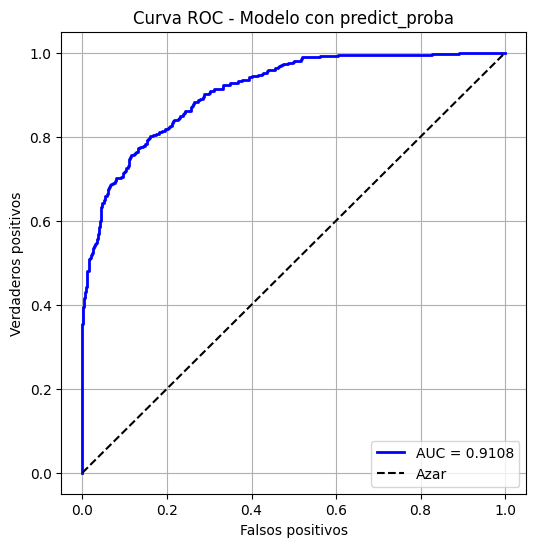

AUC-ROC en test: 0.9108
F1 Score en test: 0.7325
Accuracy en test: 0.8673


In [50]:

best_model = grid_search.best_estimator_

y_pred = best_model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Azar")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Modelo con predict_proba")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC-ROC en test: {auc:.4f}")
print(f"F1 Score en test: {f1_score(y_test, y_pred.round()):.4f}")
print(f"Accuracy en test: {accuracy_score(y_test, y_pred.round()):.4f}")


Esta es un prediccion de que tan probable es que un cliente se vaya

In [51]:

y_pred_class = best_model.predict(x_test)

auc = roc_auc_score(y_test, y_pred_class)
print(f"AUC-ROC con predicciones binarias: {auc:.4f}")


AUC-ROC con predicciones binarias: 0.8089


c:\Python\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


El valor AUC obtenido con predicciones binarias .predict() no refleja adecuadamente el poder del modelo, ya que el AUC-ROC está diseñado para trabajar con probabilidades continuas generadas por predict_proba().

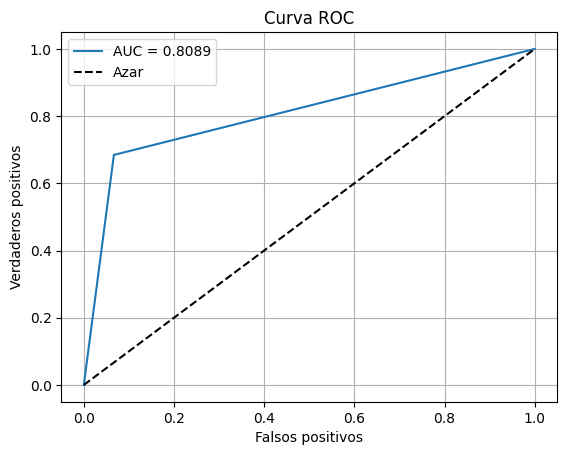

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_class)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar")
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()


El modelo distingue correctamente entre clientes que cancelan y los que no, el 91% de las veces